In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json

Configure the ERDDAP to search

In [2]:
ra = 'aoos'

with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

http://erddap.aoos.org/erddap


Pull in the processed inventory

In [3]:
#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).

df = pd.read_excel('2022/data/processed/%s.xlsx' % ra.upper(), dtype=str)
df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,AOOS,CSESM,NaN,Chukchi Sea Ecosystem Mooring (CSESM) Array,Hannah Shoal subsurface ecosystem mooring; Sea...,71.6,-161.5,moored_buoy,2015-09-01 00:00:00,Y,"AOOS, NPRB, UAF, others",Yp,UAF_CFOS,Academic,UAF,AOOS,"sea_water_temperature (35m, 48m, near-bottom),...",Rotated Annually. ~1 year lag on data ingesti...
1,AOOS,urn:gulf-of-alaska-ecosystem-obse,NaN,Gulf of Alaska Ecosystem Observatory-GEO1,"Surface real time mooring: CDOM, 150kHz ADCP, ...",59.0142,-148.6902,Fixed moored_buoy,2019-07-11 00:00:00,Y,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,AOOS,"Real time mooring: 150kHz ADCP (205m), SBE 37 ...",The buoy was not serving real time data feeds ...
2,AOOS,urn:gulf-of-alaska-ecosystem-obse-1,NaN,Gulf of Alaska Ecosystem Observatory-GEO3,"Surface real time mooring: GPS, wind speed, wi...",59.0165,-148.696,Fixed moored_buoy,2019-07-11 00:00:00,Y,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,AOOS,"Real time mooring: GPS, wind_speed, wind_from_...","Note: The 5 m SBE 37 CTD (Conductivity, temper..."
3,AOOS,urn:ioos:station:org.gulfwatchalaska:GAK1,NaN,Oceanographic Station GAK1,Longterm non-realtime physcial parameters moor...,59.845,-149.466667,moored_buoy,1905-06-20 00:00:00,Y,"UAF, Exxon Valdez Oil Spill Trustees Council, ...",N,UAF_CFOS,Academic,UAF CFOS,"UAF, AOOS","NOT REAL TIME: sea_water_temperature (30 m, 60...",Subsurface mooring collecting CTD paramaters; ...
4,AOOS,urn:ioos:station:gov.noaa.pmel:GAK_Seward,NaN,GAKOA-Gulf of Alaska Ocean Acidification Mooring,"Resurrection Bay, Seward, Real-time OA parameters",59.85,-149.5,moored_buoy,2011-05-19 00:00:00,Y,"AOOS, NOAA",Yp,NOAA_PMEL,gov_federal,"NOAA PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, these data are Not repo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,AOOS,skan-bay-unalaska-island-ak,NaN,"Skan Bay Weather Station, Unalaska Island, AK","MET Station in Skan Bay, Unalaska, AK",53.6185,-167.0628,Fixed,2022-08-16 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of North Carolina, Willimington (UNCW)",UNCW,"air_pressure, dew_point_temperature, relative_...","NSF Bering Sea Storms Project, Sea Level Resea..."
124,AOOS,shagak-bay-inner-wave-buoy,NaN,Shagak Bay Inner Wave Buoy,SOFAR Spotter Wave Buoy in Shagak Bay,51.8744,-176.7443,Moored Buoy,2022-08-12 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of North Carolina, Willimington (UNCW)",SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...","NSF Bering Sea Storms Project, Sea Level Resea..."
125,AOOS,st-paul-island-wave-buoy,NaN,St. Paul Island Wave Buoy,SOFAR Spotter Wave Buoy in Skan Bay (outer bay),57.1208,-170.3825,Moored Buoy,2022-09-20 00:00:00,O,"University of Alaksa, Fairbanks Geophysical In...",N,NaN,Academic,UAF GI,SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...",Project buoy deployments for which AOOS is sha...
126,AOOS,noaa_nos_co_ops_9454050,CRVA2,"Cordova, AK",NOAA NWLON station in Cordova equipped with AO...,60.5583,-145.755,Fixed,Tide Gage: 08/31/78; NWLON CTD installed 11/03...,Y,"NOAA CO-OPS, AOOS",Yp,NOAA _NWLON,Federal,PWSSC-Prince William Sound Science Center,NOAA CO-OPS,"air_pressure, sea_water_electrical_conductivit...",I have added this station so IOOS knows that A...


Search the ERDDAP server for a single station of interest - more of a test

In [4]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [5]:
# df_wf = df[df['Station ID'] == 'Jug_Bay']

# # for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
# search_for = df_wf['Station ID'].to_string()

# search_url = e.get_search_url(search_for=search_for, response="csv")

# try:
#     resp = pd.read_csv(search_url)
#     print(resp['Station ID'])
# except:
#     pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [6]:
not_found = []
found = dict()

exclude = ' -gliders'

#search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']

# GLOS
search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']
# SCCOOS
#search_order = ['Station Long Name', 'WMO ID or NWS/CMAN ID', 'Station Description']

for search1 in df[search_order[0]].astype(str):
    
    if search1 == "nan":
        print("punting with %s = nan\n" % search_order[0])
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

searching "Station ID" = "CSESM"
no dataset matching "CSESM"
searching "Station Long Name" = "Chukchi Sea Ecosystem Mooring (CSESM) Array"
punting with "WMO ID or NWS/CMAN ID" = nan

searching "Station ID" = "urn:gulf-of-alaska-ecosystem-obse"
no dataset matching "urn:gulf-of-alaska-ecosystem-obse"
searching "Station Long Name" = "Gulf of Alaska Ecosystem Observatory-GEO1"
punting with "WMO ID or NWS/CMAN ID" = nan

searching "Station ID" = "urn:gulf-of-alaska-ecosystem-obse-1"
no dataset matching "urn:gulf-of-alaska-ecosystem-obse-1"
searching "Station Long Name" = "Gulf of Alaska Ecosystem Observatory-GEO3"
punting with "WMO ID or NWS/CMAN ID" = nan

searching "Station ID" = "urn:ioos:station:org.gulfwatchalaska:GAK1"
no dataset matching "urn:ioos:station:org.gulfwatchalaska:GAK1"
searching "Station Long Name" = "Oceanographic Station GAK1"
punting with "WMO ID or NWS/CMAN ID" = nan

searching "Station ID" = "urn:ioos:station:gov.noaa.pmel:GAK_Seward"
no dataset matching "urn:ioos:st

no dataset matching "urn:ioos:station:org.mxak:KENAI"
searching "Station Long Name" = "Kenai"
Found "Kenai": ['gov_usgs_waterdata_15258000', 'gov_usgs_waterdata_15266300', 'gov_usgs_waterdata_15266110', 'org_mxak_kenai', 'gov_noaa_uscrn_1753', 'noaa_nos_co_ops_9455742', 'raws_akaklk', 'gov_usda_nrcs_sntl_966', 'raws_akaken', 'noaa_nos_co_ops_twc1983', 'gov_noaa_water_keya2', 'org_circac_147', 'gov_noaa_awc_paen', 'noaa_nos_co_ops_9455128']


searching "Station ID" = "urn:ioos:station:org.mxak:KETCHIKAN"
no dataset matching "urn:ioos:station:org.mxak:KETCHIKAN"
searching "Station Long Name" = "Ketichikan Harbor"
searching "WMO ID or NWS/CMAN ID" = " KEXA2"
Couldn't find: ['urn:ioos:station:org.mxak:KETCHIKAN', 'Ketichikan Harbor', ' KEXA2']


searching "Station ID" = "urn:ioos:station:org.mxak:SALMON_LANDING"
no dataset matching "urn:ioos:station:org.mxak:SALMON_LANDING"
searching "Station Long Name" = "Ketchikan, Salmon Landing"
searching "WMO ID or NWS/CMAN ID" = " SLXA2"
Couldn't fin

no dataset matching "urn:ioos:station:org.mxak:MIDDLETON_ISLAND"
searching "Station Long Name" = "Middleton Island"
Found "Middleton Island": ['org_mxak_middleton_island', 'noaa_nos_co_ops_9454224', 'gov_noaa_awc_pamd']


searching "Station ID" = "midway-island"
Found "midway-island": ['midway-island']


searching "Station ID" = "urn:ioos:station:org.mxak:MXAK_OFFICE"
no dataset matching "urn:ioos:station:org.mxak:MXAK_OFFICE"
searching "Station Long Name" = "MXAK Office"
Found "MXAK Office": ['org_mxak_mxak_office']


searching "Station ID" = "urn:ioos:station:org.mxak:NAKED_ISLAND"
no dataset matching "urn:ioos:station:org.mxak:NAKED_ISLAND"
searching "Station Long Name" = "Naked Island"
Found "Naked Island": ['net_cvinternet_naked', 'noaa_nos_co_ops_9454563']


searching "Station ID" = "nelson-lagoon-1"
Found "nelson-lagoon-1": ['nelson-lagoon-1']


searching "Station ID" = "urn:ioos:station:org.mxak:NIKISKI"
no dataset matching "urn:ioos:station:org.mxak:NIKISKI"
searching "Station

Found "Alyeska Resort, Mid Mountain": ['alyeska-resort-mid-mountain-ak', 'alyeska-resort-max-s-mountain-ak']


searching "Station ID" = "urn:ioos:station:com.alyeska:summitsite"
no dataset matching "urn:ioos:station:com.alyeska:summitsite"
searching "Station Long Name" = "Alyeska Resort Summit"
Found "Alyeska Resort Summit": ['alyeska-resort-summit-ak']


searching "Station ID" = "urn:ioos:station:com.alyeska:ALY_TOP_HR"
no dataset matching "urn:ioos:station:com.alyeska:ALY_TOP_HR"
searching "Station Long Name" = "Alyeska Resort, Top of Glacier Bowl Express"
Found "Alyeska Resort, Top of Glacier Bowl Express": ['alyeska-resort-top-of-glacier-bo']


searching "Station ID" = "kodiak-burke-o-lator-kodiak-ak"
Found "kodiak-burke-o-lator-kodiak-ak": ['kodiak-burke-o-lator-kodiak-ak']


searching "Station ID" = "urn:ioos:station:org.hakai:Sitka"
no dataset matching "urn:ioos:station:org.hakai:Sitka"
searching "Station Long Name" = "Sitka Burke-o-Lator"
Found "Sitka Burke-o-Lator": ['org_haka

Found "st-paul-island-wave-buoy": ['st-paul-island-wave-buoy']


searching "Station ID" = "noaa_nos_co_ops_9454050"
Found "noaa_nos_co_ops_9454050": ['noaa_nos_co_ops_9454050']


searching "Station ID" = "noaa_nos_co_ops_9454240"
Found "noaa_nos_co_ops_9454240": ['noaa_nos_co_ops_9454240']




Print the stations that we couldn't find.

In [7]:
len(not_found)

28

In [8]:
len(found)

100

Show me the record that has NaN for the first search element.

In [9]:
df.loc[df[search_order[0]].isna()]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes


Now show me the stations, with identifiers, that we couldn't find.

In [10]:
df[df[search_order[0]].isin(not_found)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,AOOS,CSESM,NaN,Chukchi Sea Ecosystem Mooring (CSESM) Array,Hannah Shoal subsurface ecosystem mooring; Sea...,71.6,-161.5,moored_buoy,2015-09-01 00:00:00,Y,"AOOS, NPRB, UAF, others",Yp,UAF_CFOS,Academic,UAF,AOOS,"sea_water_temperature (35m, 48m, near-bottom),...",Rotated Annually. ~1 year lag on data ingesti...
1,AOOS,urn:gulf-of-alaska-ecosystem-obse,NaN,Gulf of Alaska Ecosystem Observatory-GEO1,"Surface real time mooring: CDOM, 150kHz ADCP, ...",59.0142,-148.6902,Fixed moored_buoy,2019-07-11 00:00:00,Y,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,AOOS,"Real time mooring: 150kHz ADCP (205m), SBE 37 ...",The buoy was not serving real time data feeds ...
2,AOOS,urn:gulf-of-alaska-ecosystem-obse-1,NaN,Gulf of Alaska Ecosystem Observatory-GEO3,"Surface real time mooring: GPS, wind speed, wi...",59.0165,-148.696,Fixed moored_buoy,2019-07-11 00:00:00,Y,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,AOOS,"Real time mooring: GPS, wind_speed, wind_from_...","Note: The 5 m SBE 37 CTD (Conductivity, temper..."
3,AOOS,urn:ioos:station:org.gulfwatchalaska:GAK1,NaN,Oceanographic Station GAK1,Longterm non-realtime physcial parameters moor...,59.845,-149.466667,moored_buoy,1905-06-20 00:00:00,Y,"UAF, Exxon Valdez Oil Spill Trustees Council, ...",N,UAF_CFOS,Academic,UAF CFOS,"UAF, AOOS","NOT REAL TIME: sea_water_temperature (30 m, 60...",Subsurface mooring collecting CTD paramaters; ...
4,AOOS,urn:ioos:station:gov.noaa.pmel:GAK_Seward,NaN,GAKOA-Gulf of Alaska Ocean Acidification Mooring,"Resurrection Bay, Seward, Real-time OA parameters",59.85,-149.5,moored_buoy,2011-05-19 00:00:00,Y,"AOOS, NOAA",Yp,NOAA_PMEL,gov_federal,"NOAA PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, these data are Not repo..."
5,AOOS,urn:ioos:station:gov.noaa.pmel:m2,NaN,Ocean Acidification Mooring M2 and Ecosytem Ob...,"Bering Sea, Real-time OA parameters",56.87,-164.06,moored_buoy,1905-07-03 00:00:00,Y,"AOOS, NOAA",Yp,NOAA_PMEL,gov_federal,"NOAA, PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, the data are Not report..."
11,AOOS,urn:ioos:station:org.mxak:CAPTAINS_BAY,CPXA2,Captains Bay - Dutch Harbor,WEATHER (No AIS),53.842909,-166.583242,Fixed,2018-12-12 00:00:00,Y,AOOS,Yf,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN
13,AOOS,urn:ioos:station:org.mxak:DEAD_HORSE,DHXA2,"Deadhorse, Prudhoe Bay",AIS TRANSCEIVER WITH WEATHER,70.22235,-148.419267,Fixed,10/01/15; 9/30/2015,Y,AOOS,Yf,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...","AOOS webstie record starts September 15, 2015...."
16,AOOS,urn:ioos:station:org.mxak:DUTCH_HARBOR_PORT_OF...,DPOA2,Dutch Harbor - Port Office,WEATHER (NO AIS),53.902729,-166.5284,Fixed,07/02/15; 5/5/15,Y,MXAK,N,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN
18,AOOS,urn:ioos:station:org.mxak:GAMBELL,BGBXA2,"Gambell, St. Lawrence Island",Weather and AIS eATON/Transceiver,63.776913,-171.71531,Fixed,2019-05-31 00:00:00,Y,"AOOS, MXAK",Yp,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN


Print out all the dataset IDs for the datasets that matched our criteria.

In [11]:
found

{'urn:ioos:station:org.mxak:AKUTAN_WX': {'Dataset ID': ['akutan-1',
   'noaa_nos_co_ops_9462691',
   'noaa_nos_co_ops_9462694',
   'noaa_nos_co_ops_9462711',
   'org_mxak_akutan_wx']},
 'urn:ioos:station:org.mxak:ANCHORAGE_PORT': {'Dataset ID': ['org_mxak_anchorage_port',
   'gov_noaa_awc_pamr',
   'gov_noaa_awc_panc',
   'miscwebcam_11',
   'gov_noaa_nws_hads_ddcda04a',
   'gov_noaa_nws_hads_15cf67be',
   'gov_noaa_nws_hads_ddcd95d0',
   'gov_noaa_nws_hads_15d101ae',
   'gov_usgs_waterdata_15276000',
   'gov_noaa_awc_paed',
   'gov_noaa_awc_palh',
   'gov_usgs_waterdata_15275100',
   'noaa_nos_co_ops_9451826',
   'noaa_nos_co_ops_9459464',
   'noaa_nos_co_ops_9454573',
   'noaa_nos_co_ops_9450271',
   'noaa_nos_co_ops_9450862',
   'noaa_nos_co_ops_9458917',
   'noaa_nos_co_ops_9450544',
   'noaa_nos_co_ops_9455920',
   'gov_usda_nrcs_sntl_1070']},
 'org_mxak_bethel': {'Dataset ID': ['org_mxak_bethel']},
 'urn:ioos:station:org.mxak:CAPE_DECISION': {'Dataset ID': ['gov_noaa_nws_cdea2']}

Check if each found dataset has coverage for specified CY

In [12]:
valid_datasets = []

cy = '2022'

for key in found:
    
    dataset_id = found[key]['Dataset ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "{}-01-01".format(cy)
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:
                pass

                #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "{}-01-01".format(cy)
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

no_cov_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for {}:\n{}'.format(cy,no_cov_datasets))

Datasets without coverage for 2022:
{'kodiak-burke-o-lator-kodiak-ak', 'naknek-ak', 'noaa_nos_co_ops_9454240', 'urn:ioos:station:gov.usda.nrcs.wcc.snotel:1076', 'kivalina-alaska-water-level', 'scott-glacier', 'homer-ramp-8', 'mount-riley-1', 'urn:ioos:station:org.inletkeeper:anchor-river', 'urn:ioos:station:com.alyeska:aly_mid_hr', 'urn:ioos:station:gov.noaa.water:TNUA2', 'cape_st_elias', 'camel-bay-outer-wave-buoy', 'urn:ioos:station:org.mxak:WAINWRIGHT', 'harbor-mountain-1', 'st-michaels-bay-ak', 'urn:ioos:station:aoos:204', 'deering-alaska-water-level', 'urn:ioos:station:gov.usda.nrcs.wcc.snotel:1088', 'skan-bay-inner-wave-buoy', 'urn:ioos:station:gov.usda.nrcs.wcc.snotel:1075', 'kipnuk-alaska-water-level', 'quail-bay-inner-wave-buoy', 'org_hakai_quadra', 'kotzebue-alaska-water-level', 'ward-cove', 'urn:ioos:station:com.alyeska:maxsmtn', 'barry-arm-east', 'urn:ioos:station:com.alyeska:summitsite', 'nelson-lagoon-alaska-water-le', 'urn:ioos:station:com.alyeska:ALY_TOP_HR', 'utqiagvik

Show me the inventory metadata about the invalid stations:

In [13]:
bad_stations = df.loc[(df[search_order[0]].isin(no_cov_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

df.loc[df['erddap_not_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes,erddap_not_avail
0,AOOS,CSESM,NaN,Chukchi Sea Ecosystem Mooring (CSESM) Array,Hannah Shoal subsurface ecosystem mooring; Sea...,71.6,-161.5,moored_buoy,2015-09-01 00:00:00,Y,"AOOS, NPRB, UAF, others",Yp,UAF_CFOS,Academic,UAF,AOOS,"sea_water_temperature (35m, 48m, near-bottom),...",Rotated Annually. ~1 year lag on data ingesti...,True
1,AOOS,urn:gulf-of-alaska-ecosystem-obse,NaN,Gulf of Alaska Ecosystem Observatory-GEO1,"Surface real time mooring: CDOM, 150kHz ADCP, ...",59.0142,-148.6902,Fixed moored_buoy,2019-07-11 00:00:00,Y,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,AOOS,"Real time mooring: 150kHz ADCP (205m), SBE 37 ...",The buoy was not serving real time data feeds ...,True
2,AOOS,urn:gulf-of-alaska-ecosystem-obse-1,NaN,Gulf of Alaska Ecosystem Observatory-GEO3,"Surface real time mooring: GPS, wind speed, wi...",59.0165,-148.696,Fixed moored_buoy,2019-07-11 00:00:00,Y,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,AOOS,"Real time mooring: GPS, wind_speed, wind_from_...","Note: The 5 m SBE 37 CTD (Conductivity, temper...",True
3,AOOS,urn:ioos:station:org.gulfwatchalaska:GAK1,NaN,Oceanographic Station GAK1,Longterm non-realtime physcial parameters moor...,59.845,-149.466667,moored_buoy,1905-06-20 00:00:00,Y,"UAF, Exxon Valdez Oil Spill Trustees Council, ...",N,UAF_CFOS,Academic,UAF CFOS,"UAF, AOOS","NOT REAL TIME: sea_water_temperature (30 m, 60...",Subsurface mooring collecting CTD paramaters; ...,True
4,AOOS,urn:ioos:station:gov.noaa.pmel:GAK_Seward,NaN,GAKOA-Gulf of Alaska Ocean Acidification Mooring,"Resurrection Bay, Seward, Real-time OA parameters",59.85,-149.5,moored_buoy,2011-05-19 00:00:00,Y,"AOOS, NOAA",Yp,NOAA_PMEL,gov_federal,"NOAA PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, these data are Not repo...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,AOOS,quail-bay-outer-wave-buoy,NaN,Quail Bay Outer Wave Buoy,SOFAR Spotter Wave Buoy - Outer Quail Bay,51.7383,-176.3032,Moored Buoy,2022-08-16 00:00:00,Y,"NSF, UNCW-CMS",N,"University of North Carolina (UNC), CMS",Academic,"University of North Carolina, Willimington (UNCW)",SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...","NSF Bering Sea Storms Project, Sea Level Resea...",True
121,AOOS,skan-bay-inner-wave-buoy,NaN,Skan Bay Inner Wave Buoy,SOFAR Spotter Wave Buoy in Skan Bay (inner bay),53.6151,-167.0489,Moored Buoy,2021-08-27 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of North Carolina, Willimington (UNCW)",SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...","NSF Bering Sea Storms Project, Sea Level Resea...",True
122,AOOS,skan-bay-outer-wave-buoy,NaN,Skan Bay Outer Wave Buoy,SOFAR Spotter Wave Buoy in Skan Bay (outer bay),53.6315,-167.0598,Moored Buoy,2021-08-27 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of North Carolina, Willimington (UNCW)",SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...","NSF Bering Sea Storms Project, Sea Level Resea...",True
124,AOOS,shagak-bay-inner-wave-buoy,NaN,Shagak Bay Inner Wave Buoy,SOFAR Spotter Wave Buoy in Shagak Bay,51.8744,-176.7443,Moored Buoy,2022-08-12 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of North Carolina, Willimington (UNCW)",SOFAR OCEAN,"sea_surface_wave_significant_h

Invert the `erddap_not_avail` column and drop it.

In [14]:
df['erddap_avail'] = ~df['erddap_not_avail']

df.drop(columns='erddap_not_avail', inplace=True)

df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes,erddap_avail
0,AOOS,CSESM,NaN,Chukchi Sea Ecosystem Mooring (CSESM) Array,Hannah Shoal subsurface ecosystem mooring; Sea...,71.6,-161.5,moored_buoy,2015-09-01 00:00:00,Y,"AOOS, NPRB, UAF, others",Yp,UAF_CFOS,Academic,UAF,AOOS,"sea_water_temperature (35m, 48m, near-bottom),...",Rotated Annually. ~1 year lag on data ingesti...,False
1,AOOS,urn:gulf-of-alaska-ecosystem-obse,NaN,Gulf of Alaska Ecosystem Observatory-GEO1,"Surface real time mooring: CDOM, 150kHz ADCP, ...",59.0142,-148.6902,Fixed moored_buoy,2019-07-11 00:00:00,Y,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,AOOS,"Real time mooring: 150kHz ADCP (205m), SBE 37 ...",The buoy was not serving real time data feeds ...,False
2,AOOS,urn:gulf-of-alaska-ecosystem-obse-1,NaN,Gulf of Alaska Ecosystem Observatory-GEO3,"Surface real time mooring: GPS, wind speed, wi...",59.0165,-148.696,Fixed moored_buoy,2019-07-11 00:00:00,Y,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,AOOS,"Real time mooring: GPS, wind_speed, wind_from_...","Note: The 5 m SBE 37 CTD (Conductivity, temper...",False
3,AOOS,urn:ioos:station:org.gulfwatchalaska:GAK1,NaN,Oceanographic Station GAK1,Longterm non-realtime physcial parameters moor...,59.845,-149.466667,moored_buoy,1905-06-20 00:00:00,Y,"UAF, Exxon Valdez Oil Spill Trustees Council, ...",N,UAF_CFOS,Academic,UAF CFOS,"UAF, AOOS","NOT REAL TIME: sea_water_temperature (30 m, 60...",Subsurface mooring collecting CTD paramaters; ...,False
4,AOOS,urn:ioos:station:gov.noaa.pmel:GAK_Seward,NaN,GAKOA-Gulf of Alaska Ocean Acidification Mooring,"Resurrection Bay, Seward, Real-time OA parameters",59.85,-149.5,moored_buoy,2011-05-19 00:00:00,Y,"AOOS, NOAA",Yp,NOAA_PMEL,gov_federal,"NOAA PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, these data are Not repo...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,AOOS,skan-bay-unalaska-island-ak,NaN,"Skan Bay Weather Station, Unalaska Island, AK","MET Station in Skan Bay, Unalaska, AK",53.6185,-167.0628,Fixed,2022-08-16 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of North Carolina, Willimington (UNCW)",UNCW,"air_pressure, dew_point_temperature, relative_...","NSF Bering Sea Storms Project, Sea Level Resea...",True
124,AOOS,shagak-bay-inner-wave-buoy,NaN,Shagak Bay Inner Wave Buoy,SOFAR Spotter Wave Buoy in Shagak Bay,51.8744,-176.7443,Moored Buoy,2022-08-12 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of North Carolina, Willimington (UNCW)",SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...","NSF Bering Sea Storms Project, Sea Level Resea...",False
125,AOOS,st-paul-island-wave-buoy,NaN,St. Paul Island Wave Buoy,SOFAR Spotter Wave Buoy in Skan Bay (outer bay),57.1208,-170.3825,Moored Buoy,2022-09-20 00:00:00,O,"University of Alaksa, Fairbanks Geophysical In...",N,NaN,Academic,UAF GI,SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...",Project buoy deployments for which AOOS is sha...,True
126,AOOS,noaa_nos_co_ops_9454050,CRVA2,"Cordova, AK",NOAA NWLON station in Cordova equipped with AO...,60.5583,-145.755,Fixed,Tide Gage: 08/31/78; NWLON CTD installed 11/03...,Y,"NOAA CO-OPS, AOOS",Yp,NOAA _NWLON,Federal,PWSSC-Prince William Sound Science Center,NOAA CO-OPS,"air_pressure, sea_water_electrical_conductivit...",I have added this station so IOOS knows that 

Make a plot of all points and color based on ERDDAP available or not.

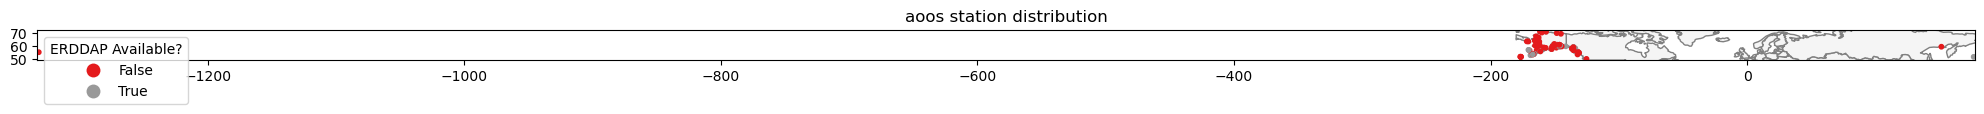

In [15]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [16]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.loc[~gdf_final['geometry'].is_empty == True].drop(columns='Variable Names').explore('erddap_avail',cmap = 'Set1')


## Show me some bad coordinates

_if there are any_

In [17]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry


In [18]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

# Show me the stations where ERDDAP doesn't exist or provide a valid response.

Reasons:
* Station not found on RA erddap
* dataset found but no data for this CY.

In [19]:
gdf_final.loc[~gdf_final['erddap_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry
0,AOOS,CSESM,NaN,Chukchi Sea Ecosystem Mooring (CSESM) Array,Hannah Shoal subsurface ecosystem mooring; Sea...,71.6,-161.5,moored_buoy,2015-09-01 00:00:00,Y,"AOOS, NPRB, UAF, others",Yp,UAF_CFOS,Academic,UAF,AOOS,"sea_water_temperature (35m, 48m, near-bottom),...",Rotated Annually. ~1 year lag on data ingesti...,False,POINT (-161.50000 71.60000)
1,AOOS,urn:gulf-of-alaska-ecosystem-obse,NaN,Gulf of Alaska Ecosystem Observatory-GEO1,"Surface real time mooring: CDOM, 150kHz ADCP, ...",59.0142,-148.6902,Fixed moored_buoy,2019-07-11 00:00:00,Y,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,AOOS,"Real time mooring: 150kHz ADCP (205m), SBE 37 ...",The buoy was not serving real time data feeds ...,False,POINT (-148.69020 59.01420)
2,AOOS,urn:gulf-of-alaska-ecosystem-obse-1,NaN,Gulf of Alaska Ecosystem Observatory-GEO3,"Surface real time mooring: GPS, wind speed, wi...",59.0165,-148.696,Fixed moored_buoy,2019-07-11 00:00:00,Y,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,AOOS,"Real time mooring: GPS, wind_speed, wind_from_...","Note: The 5 m SBE 37 CTD (Conductivity, temper...",False,POINT (-148.69600 59.01650)
3,AOOS,urn:ioos:station:org.gulfwatchalaska:GAK1,NaN,Oceanographic Station GAK1,Longterm non-realtime physcial parameters moor...,59.845,-149.466667,moored_buoy,1905-06-20 00:00:00,Y,"UAF, Exxon Valdez Oil Spill Trustees Council, ...",N,UAF_CFOS,Academic,UAF CFOS,"UAF, AOOS","NOT REAL TIME: sea_water_temperature (30 m, 60...",Subsurface mooring collecting CTD paramaters; ...,False,POINT (-149.46667 59.84500)
4,AOOS,urn:ioos:station:gov.noaa.pmel:GAK_Seward,NaN,GAKOA-Gulf of Alaska Ocean Acidification Mooring,"Resurrection Bay, Seward, Real-time OA parameters",59.85,-149.5,moored_buoy,2011-05-19 00:00:00,Y,"AOOS, NOAA",Yp,NOAA_PMEL,gov_federal,"NOAA PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, these data are Not repo...",False,POINT (-149.50000 59.85000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,AOOS,quail-bay-outer-wave-buoy,NaN,Quail Bay Outer Wave Buoy,SOFAR Spotter Wave Buoy - Outer Quail Bay,51.7383,-176.3032,Moored Buoy,2022-08-16 00:00:00,Y,"NSF, UNCW-CMS",N,"University of North Carolina (UNC), CMS",Academic,"University of North Carolina, Willimington (UNCW)",SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...","NSF Bering Sea Storms Project, Sea Level Resea...",False,POINT (-176.30320 51.73830)
121,AOOS,skan-bay-inner-wave-buoy,NaN,Skan Bay Inner Wave Buoy,SOFAR Spotter Wave Buoy in Skan Bay (inner bay),53.6151,-167.0489,Moored Buoy,2021-08-27 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of North Carolina, Willimington (UNCW)",SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...","NSF Bering Sea Storms Project, Sea Level Resea...",False,POINT (-167.04890 53.61510)
122,AOOS,skan-bay-outer-wave-buoy,NaN,Skan Bay Outer Wave Buoy,SOFAR Spotter Wave Buoy in Skan Bay (outer bay),53.6315,-167.0598,Moored Buoy,2021-08-27 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of North Carolina, Willimington (UNCW)",SOFAR OCEAN,"sea_surface_wave_significant_height, sea_surfa...","NSF Bering Sea Storms Project, Sea Level Resea...",False,POINT (-167.05980 53.63150)
124,AOOS,shagak-bay-inner-wave-buoy,NaN,Shagak Bay Inner Wave Buoy,SOFAR Spotter Wave Buoy in Shagak Bay,51.8744,-176.7443,Moored Buoy,2022-08-12 00:00:00,Y,"NSF, UNCW-CMS",N,UNCW-Coastal Ocean Research and Monitoring Pro...,Academic,"University of Nor

# Do some checking against the IOOS catalog

only for datasets that we couldn't find in ERDDAP (per above)

In [20]:
from ckanapi import RemoteCKAN
import xarray as xr

problem_datasets = []

ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog

gdf_ckan = gdf_final.loc[~gdf_final['erddap_avail']]


for station in gdf_ckan['Station ID'].dropna():

    RA = gdf_ckan.loc[gdf_ckan['Station ID']==station,'RA'].tolist()[0]
    
    print('Station "{}" + RA "{}"'.format(station.lower(), RA.lower()))
    
    # build RA tag query
    fq = '+organization:{}'.format(RA.lower())

    # build free text query
    q = "\""+station.lower()+"\""+" -glider"

    query = ioos_catalog.address + '/dataset/?' + 'q=' + q + '&organization=' + RA.lower()
    
    print('Query: {}'.format(query.replace(" ","%20")))

    datasets = ioos_catalog.action.package_search(q=q, fq=fq)

    

    if datasets['count'] > 0:
        print('\tfound {} dataset(s):'.format(datasets['count']))
        
        for dataset in datasets['results']:
            print('\t',dataset['title'])
            
            
            if dataset['resources']:
                print('\t',dataset['resources'][0]['url'])

                start_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-begin")['value']
                end_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-end")['value']

                print('\t','Coverage Meta:\n\t\t', start_date,' - ',end_date,'\n')

                if 'thredds' in dataset['resources'][0]['url']:
                    ds = xr.open_dataset(dataset['resources'][0]['url'])

                    time_max = ds.time.max().values

                    time_min = ds.time.min().values


                    print('\tCoverage Data:\n\t\t', time_min,' - ',time_max, '\n')

                    if pd.to_datetime(end_date) < pd.to_datetime(time_max, utc=True):
                        test_date = pd.to_datetime(time_max, utc=True)

                else:
                    test_date = pd.to_datetime(end_date, utc=True)

                if test_date > pd.to_datetime('{}-01-01'.format(cy), utc=True):
                    print('\t{} is valid.'.format(station))
                    break
                else:
                    print('\t{} is not valid.'.format(station))

                    problem_datasets.append(station)
            
            else:
                print('\t{} missing additional metadata'.format(station))
                problem_datasets.append(station)
    else:
        print("\tNo datasets found!")
        problem_datasets.append(station)

Station "csesm" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="csesm"%20-glider&organization=aoos
	No datasets found!
Station "urn:gulf-of-alaska-ecosystem-obse" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="urn:gulf-of-alaska-ecosystem-obse"%20-glider&organization=aoos
	No datasets found!
Station "urn:gulf-of-alaska-ecosystem-obse-1" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="urn:gulf-of-alaska-ecosystem-obse-1"%20-glider&organization=aoos
	No datasets found!
Station "urn:ioos:station:org.gulfwatchalaska:gak1" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="urn:ioos:station:org.gulfwatchalaska:gak1"%20-glider&organization=aoos
	No datasets found!
Station "urn:ioos:station:gov.noaa.pmel:gak_seward" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="urn:ioos:station:gov.noaa.pmel:gak_seward"%20-glider&organization=aoos
	No datasets found!
Station "urn:ioos:station:gov.noaa.pmel:m2" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="urn:ioos:station:gov.noaa.pme

	found 1 dataset(s):
	 Mt. Doran
	 https://erddap.aoos.org/erddap/tabledap/mt-doran
	 Coverage Meta:
		 2021-08-04T18:15:00Z  -  2023-03-05T19:30:00Z 

	mt-doran is valid.
Station "mount-riley-1" + RA "aoos "
Query: https://data.ioos.us/dataset/?q="mount-riley-1"%20-glider&organization=aoos%20
	found 1 dataset(s):
	 Mount Riley
	 https://erddap.aoos.org/erddap/tabledap/mount-riley-1
	 Coverage Meta:
		 2021-06-24T16:30:00Z  -  2023-03-06T10:15:00Z 

	mount-riley-1 is valid.
Station "scott-glacier" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="scott-glacier"%20-glider&organization=aoos
	found 1 dataset(s):
	 Scott Glacier
	 https://erddap.aoos.org/erddap/tabledap/scott-glacier
	 Coverage Meta:
		 2015-02-04T20:16:00Z  -  2023-03-06T01:03:00Z 

	scott-glacier is valid.
Station "cape-spencer-ak" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="cape-spencer-ak"%20-glider&organization=aoos
	found 2 dataset(s):
	 Cape Spencer, AK
	 https://erddap.aoos.org/erddap/tabledap/cape-spence

	found 1 dataset(s):
	 Camel Bay Outer Wave Buoy
	 https://erddap.aoos.org/erddap/tabledap/camel-bay-outer-wave-buoy
	 Coverage Meta:
		 2022-08-16T00:03:49Z  -  2023-03-03T06:22:01Z 

	camel-bay-outer-wave-buoy is valid.
Station "quail-bay-inner-wave-buoy" + RA "aoos "
Query: https://data.ioos.us/dataset/?q="quail-bay-inner-wave-buoy"%20-glider&organization=aoos%20
	found 1 dataset(s):
	 Quail Bay Inner Wave Buoy
	 https://erddap.aoos.org/erddap/tabledap/quail-bay-inner-wave-buoy
	 Coverage Meta:
		 2022-08-17T00:18:31Z  -  2023-03-04T22:59:01Z 

	quail-bay-inner-wave-buoy is valid.
Station "quail-bay-outer-wave-buoy" + RA "aoos"
Query: https://data.ioos.us/dataset/?q="quail-bay-outer-wave-buoy"%20-glider&organization=aoos
	found 1 dataset(s):
	 Quail Bay Outer Wave Buoy
	 https://erddap.aoos.org/erddap/tabledap/quail-bay-outer-wave-buoy
	 Coverage Meta:
		 2022-08-17T00:19:31Z  -  2023-03-04T22:36:28Z 

	quail-bay-outer-wave-buoy is valid.
Station "skan-bay-inner-wave-buoy" + RA "aoo

Check the datasets that didn't have coverage in ERDDAP or through IOOS catalog and see if they are **Currently Operational?**

In [21]:
gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry
0,AOOS,CSESM,NaN,Chukchi Sea Ecosystem Mooring (CSESM) Array,Hannah Shoal subsurface ecosystem mooring; Sea...,71.6,-161.5,moored_buoy,2015-09-01 00:00:00,Y,"AOOS, NPRB, UAF, others",Yp,UAF_CFOS,Academic,UAF,AOOS,"sea_water_temperature (35m, 48m, near-bottom),...",Rotated Annually. ~1 year lag on data ingesti...,False,POINT (-161.50000 71.60000)
1,AOOS,urn:gulf-of-alaska-ecosystem-obse,NaN,Gulf of Alaska Ecosystem Observatory-GEO1,"Surface real time mooring: CDOM, 150kHz ADCP, ...",59.0142,-148.6902,Fixed moored_buoy,2019-07-11 00:00:00,Y,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,AOOS,"Real time mooring: 150kHz ADCP (205m), SBE 37 ...",The buoy was not serving real time data feeds ...,False,POINT (-148.69020 59.01420)
2,AOOS,urn:gulf-of-alaska-ecosystem-obse-1,NaN,Gulf of Alaska Ecosystem Observatory-GEO3,"Surface real time mooring: GPS, wind speed, wi...",59.0165,-148.696,Fixed moored_buoy,2019-07-11 00:00:00,Y,"M.J. Murdock Charitable Trust, AOOS, NPRB, Gul...",Yp,UAF_CFOS,Academic,UAF,AOOS,"Real time mooring: GPS, wind_speed, wind_from_...","Note: The 5 m SBE 37 CTD (Conductivity, temper...",False,POINT (-148.69600 59.01650)
3,AOOS,urn:ioos:station:org.gulfwatchalaska:GAK1,NaN,Oceanographic Station GAK1,Longterm non-realtime physcial parameters moor...,59.845,-149.466667,moored_buoy,1905-06-20 00:00:00,Y,"UAF, Exxon Valdez Oil Spill Trustees Council, ...",N,UAF_CFOS,Academic,UAF CFOS,"UAF, AOOS","NOT REAL TIME: sea_water_temperature (30 m, 60...",Subsurface mooring collecting CTD paramaters; ...,False,POINT (-149.46667 59.84500)
4,AOOS,urn:ioos:station:gov.noaa.pmel:GAK_Seward,NaN,GAKOA-Gulf of Alaska Ocean Acidification Mooring,"Resurrection Bay, Seward, Real-time OA parameters",59.85,-149.5,moored_buoy,2011-05-19 00:00:00,Y,"AOOS, NOAA",Yp,NOAA_PMEL,gov_federal,"NOAA PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, these data are Not repo...",False,POINT (-149.50000 59.85000)
5,AOOS,urn:ioos:station:gov.noaa.pmel:m2,NaN,Ocean Acidification Mooring M2 and Ecosytem Ob...,"Bering Sea, Real-time OA parameters",56.87,-164.06,moored_buoy,1905-07-03 00:00:00,Y,"AOOS, NOAA",Yp,NOAA_PMEL,gov_federal,"NOAA, PMEL, UAF_OARC",NOAA,"dissolved_carbon_dixoide_ppm, partial_pressure...","Though AOOS Supported, the data are Not report...",False,POINT (-164.06000 56.87000)
11,AOOS,urn:ioos:station:org.mxak:CAPTAINS_BAY,CPXA2,Captains Bay - Dutch Harbor,WEATHER (No AIS),53.842909,-166.583242,Fixed,2018-12-12 00:00:00,Y,AOOS,Yf,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN,False,POINT (-166.58324 53.84291)
13,AOOS,urn:ioos:station:org.mxak:DEAD_HORSE,DHXA2,"Deadhorse, Prudhoe Bay",AIS TRANSCEIVER WITH WEATHER,70.22235,-148.419267,Fixed,10/01/15; 9/30/2015,Y,AOOS,Yf,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...","AOOS webstie record starts September 15, 2015....",False,POINT (-148.41927 70.22235)
16,AOOS,urn:ioos:station:org.mxak:DUTCH_HARBOR_PORT_OF...,DPOA2,Dutch Harbor - Port Office,WEATHER (NO AIS),53.902729,-166.5284,Fixed,07/02/15; 5/5/15,Y,MXAK,N,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska),AOOS,"dew_point_temperaure, air_temperature, air_pre...",NaN,False,POINT (-166.52840 53.90273)
18,AOOS,urn:ioos:station:org.mxak:GAMBELL,BGBXA2,"Gambell, St. Lawrence Island",Weather and AIS eATON/Transceiver,63.776913,-171.71531,Fixed,2019-05-31 00:00:00,Y,"AOOS, MXAK",Yp,Marine Exchange of Alaska,nonprofit,MXAK (Marine Exchange of Alaska)

Print out the available metadata from the IOOS Catalog for the last dataset.

In [22]:
dataset

{'author': None,
 'author_email': None,
 'creator_user_id': 'bb55ba1f-9c92-4539-a676-e1fea85df891',
 'id': '5b142e31-1244-4a12-bb7a-d94a91a7077f',
 'isopen': False,
 'license_id': None,
 'license_title': None,
 'maintainer': None,
 'maintainer_email': None,
 'metadata_created': '2023-01-18T02:17:20.513377',
 'metadata_modified': '2023-03-06T01:13:35.060369',
 'name': 'valdez-ak-vdza2',
 'notes': "Timeseries data from 'Valdez, AK (VDZA2)' (noaa_nos_co_ops_9454240)",
 'num_resources': 5,
 'num_tags': 32,
 'organization': {'id': 'eb417ed8-8ef9-46e4-8cce-deec54104134',
  'name': 'aoos',
  'title': 'AOOS',
  'type': 'organization',
  'description': '',
  'image_url': 'https://s3.amazonaws.com/ioos-us/images/AOOS_logo.jpg',
  'created': '2022-05-27T16:07:12.556672',
  'is_organization': True,
  'approval_status': 'approved',
  'state': 'active'},
 'owner_org': 'eb417ed8-8ef9-46e4-8cce-deec54104134',
 'private': False,
 'state': 'active',
 'title': 'Valdez, AK (VDZA2)',
 'type': 'dataset',
 '

In [23]:
# GLOS special case as they provide ERDDAP ID

# for dataset in gdf_final.loc[(~gdf_final['erddap_avail'] & ~gdf_final['Dataset (ERDDAP) ID'].isna()),'Dataset (ERDDAP) ID'].tolist():
#     print(dataset)
#     e.dataset_id = dataset
    
#     e.constraints = {
#                  "time>=": "{}-01-01".format(cy)
#             }
        
#     e.variables = ['time']
    
#     try:
        
#         df_data = e.to_pandas(parse_dates=True)
        
#         string = '\tDate range: {} - {}'.format(df_data.min()[0],df_data.max()[0])
        
#         print(string)
        
#         if pd.to_datetime(df_data.max()[0], utc=True) > pd.to_datetime('{}-01-01'.format(cy), utc=True):
            
#             datasetid = gdf_final.loc[gdf_final['Dataset (ERDDAP) ID']==dataset,'Station ID'].tolist()[0]
            
#             problem_datasets.remove(datasetid)
        
#     except:
#         print('\tNo valid data')

In [24]:
#gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]